**Importing dataset**

In [146]:
import numpy as np
import pandas as pd
df=pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv')


In [147]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [148]:
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


**Feature selection (crim and rm)**

In [149]:
df=df[['crim', 'rm', 'medv']]
df

,crim,rm,medv
0,0.00632,6.575,24.0
1,0.02731,6.421,21.6
2,0.02729,7.185,34.7
3,0.03237,6.998,33.4
4,0.06905,7.147,36.2
...,...,...,...
501,0.06263,6.593,22.4
502,0.04527,6.120,20.6
503,0.06076,6.976,23.9
504,0.10959,6.794,22.0


**Standardising both features between 0 to 1**

*not normalising crime rate as it is already between 0 and 1*

In [150]:
# Min-Max Scaling
df['crim_scaled'] = df['crim']
df['rm_scaled'] = (df['rm'] - df['rm'].min()) / (df['rm'].max() - df['rm'].min())

# Drop the original columns
df = df.drop(columns=['crim', 'rm'])

# Display the DataFrame
df


<ipython-input-150-38f82c8d98ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['crim_scaled'] = df['crim']
<ipython-input-150-38f82c8d98ba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rm_scaled'] = (df['rm'] - df['rm'].min()) / (df['rm'].max() - df['rm'].min())


,medv,crim_scaled,rm_scaled
0,24.0,0.00632,0.577505
1,21.6,0.02731,0.547998
2,34.7,0.02729,0.694386
3,33.4,0.03237,0.658555
4,36.2,0.06905,0.687105
...,...,...,...
501,22.4,0.06263,0.580954
502,20.6,0.04527,0.490324
503,23.9,0.06076,0.654340
504,22.0,0.10959,0.619467


In [151]:
X=df[['crim_scaled', 'rm_scaled']]
y=df[['medv']]


**Splitting into training and testing (80% train and 20% test)**

In [152]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)

In [153]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((404, 2), (404, 1), (102, 2), (102, 1))

# **Neural Network using gradient descent**




In [154]:
class Layer:
    def __init__(self, input_size, output_size, activation):
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.zeros((1, output_size))
        self.activation = activation

    def forward(self, inputs):
        self.inputs = inputs
        self.z = np.dot(inputs, self.weights) + self.bias
        return self.activation(self.z)

    def backward(self, d_output, learning_rate):
        d_z = d_output * self.activation(self.z, derivative=True)
        d_weights = np.dot(self.inputs.T, d_z)
        d_bias = np.sum(d_z, axis=0, keepdims=True)
        d_inputs = np.dot(d_z, self.weights.T)

        self.weights -= learning_rate * d_weights
        self.bias -= learning_rate * d_bias
        return d_inputs


In [155]:
def relu(x, derivative=False):
    if derivative:
        return np.where(x > 0, 1, 0)
    return np.maximum(0, x)


In [156]:
class NeuralNetwork:
    def __init__(self, input_size):
        def linear(x, derivative=False):
            return np.ones_like(x) if derivative else x

        self.layers = [
            Layer(input_size, 5, relu),
            Layer(5, 3, relu),
            Layer(3, 1, linear)
        ]

    def forward(self, X):
        X = np.array(X)
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, X, y, learning_rate):
        X, y = np.array(X), np.array(y).reshape(-1, 1)
        output = self.forward(X)
        d_output = output - y
        for layer in reversed(self.layers):
            d_output = layer.backward(d_output, learning_rate)

    def train(self, X, y, epochs, learning_rate):
        X, y = np.array(X), np.array(y).reshape(-1, 1)
        for epoch in range(epochs):
            self.backward(X, y, learning_rate)

            loss = np.mean((self.forward(X) - y) ** 2)
            print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, X):
        return self.forward(np.array(X))

**1000 epochs and learning rate of 0.01 (Exploding gradient)**

In [157]:
X_train = np.array(X_train)
y_train = np.array(y_train)

model = NeuralNetwork(input_size=X_train.shape[1])
model.train(X_train, y_train, epochs=1000, learning_rate=0.01)



Epoch 0, Loss: 4893.185533441952
Epoch 1, Loss: 44515.8862457073
Epoch 2, Loss: 410682.0384832987
Epoch 3, Loss: 3794643.151002224
Epoch 4, Loss: 35067858.16845711
Epoch 5, Loss: 324082402.0737683
Epoch 6, Loss: 2995039211.029093
Epoch 7, Loss: 27678953656.670612
Epoch 8, Loss: 255797817397.5113
Epoch 9, Loss: 2363981108544.865
Epoch 10, Loss: 21846967812012.254
Epoch 11, Loss: 201900937730776.47
Epoch 12, Loss: 1865887706132028.8
Epoch 13, Loss: 1.7243787824989048e+16
Epoch 14, Loss: 1.593601895634181e+17
Epoch 15, Loss: 1.472743127869284e+18
Epoch 16, Loss: 1.3610502890516773e+19
Epoch 17, Loss: 1.2578282351299989e+20
Epoch 18, Loss: 1.1624345417777405e+21
Epoch 19, Loss: 1.074275506129317e+22
Epoch 20, Loss: 9.928024517444699e+22
Epoch 21, Loss: 9.175083138041693e+23
Epoch 22, Loss: 8.479244832852614e+24
Epoch 23, Loss: 7.836178904729071e+25
Epoch 24, Loss: 7.241883096594418e+26
Epoch 25, Loss: 6.692658682548699e+27
Epoch 26, Loss: 6.185087448064208e+28
Epoch 27, Loss: 5.71601041600

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
<ipython-input-156-eeb114da14c1>:30: RuntimeWarning: overflow encountered in square
  loss = np.mean((self.forward(X) - y) ** 2)



Epoch 362, Loss: inf
Epoch 363, Loss: inf
Epoch 364, Loss: inf
Epoch 365, Loss: inf
Epoch 366, Loss: inf
Epoch 367, Loss: inf
Epoch 368, Loss: inf
Epoch 369, Loss: inf
Epoch 370, Loss: inf
Epoch 371, Loss: inf
Epoch 372, Loss: inf
Epoch 373, Loss: inf
Epoch 374, Loss: inf
Epoch 375, Loss: inf
Epoch 376, Loss: inf
Epoch 377, Loss: inf
Epoch 378, Loss: inf
Epoch 379, Loss: inf
Epoch 380, Loss: inf
Epoch 381, Loss: inf
Epoch 382, Loss: inf
Epoch 383, Loss: inf
Epoch 384, Loss: inf
Epoch 385, Loss: inf
Epoch 386, Loss: inf
Epoch 387, Loss: inf
Epoch 388, Loss: inf
Epoch 389, Loss: inf
Epoch 390, Loss: inf
Epoch 391, Loss: inf
Epoch 392, Loss: inf
Epoch 393, Loss: inf
Epoch 394, Loss: inf
Epoch 395, Loss: inf
Epoch 396, Loss: inf
Epoch 397, Loss: inf
Epoch 398, Loss: inf
Epoch 399, Loss: inf
Epoch 400, Loss: inf
Epoch 401, Loss: inf
Epoch 402, Loss: inf
Epoch 403, Loss: inf
Epoch 404, Loss: inf
Epoch 405, Loss: inf
Epoch 406, Loss: inf
Epoch 407, Loss: inf
Epoch 408, Loss: inf
Epoch 409, L

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-154-95a821ab8954>:13: RuntimeWarning: invalid value encountered in multiply
  d_z = d_output * self.activation(self.z, derivative=True)



Epoch 722, Loss: nan
Epoch 723, Loss: nan
Epoch 724, Loss: nan
Epoch 725, Loss: nan
Epoch 726, Loss: nan
Epoch 727, Loss: nan
Epoch 728, Loss: nan
Epoch 729, Loss: nan
Epoch 730, Loss: nan
Epoch 731, Loss: nan
Epoch 732, Loss: nan
Epoch 733, Loss: nan
Epoch 734, Loss: nan
Epoch 735, Loss: nan
Epoch 736, Loss: nan
Epoch 737, Loss: nan
Epoch 738, Loss: nan
Epoch 739, Loss: nan
Epoch 740, Loss: nan
Epoch 741, Loss: nan
Epoch 742, Loss: nan
Epoch 743, Loss: nan
Epoch 744, Loss: nan
Epoch 745, Loss: nan
Epoch 746, Loss: nan
Epoch 747, Loss: nan
Epoch 748, Loss: nan
Epoch 749, Loss: nan
Epoch 750, Loss: nan
Epoch 751, Loss: nan
Epoch 752, Loss: nan
Epoch 753, Loss: nan
Epoch 754, Loss: nan
Epoch 755, Loss: nan
Epoch 756, Loss: nan
Epoch 757, Loss: nan
Epoch 758, Loss: nan
Epoch 759, Loss: nan
Epoch 760, Loss: nan
Epoch 761, Loss: nan
Epoch 762, Loss: nan
Epoch 763, Loss: nan
Epoch 764, Loss: nan
Epoch 765, Loss: nan
Epoch 766, Loss: nan
Epoch 767, Loss: nan
Epoch 768, Loss: nan
Epoch 769, L

In [158]:
# Predict on the testing dataset
y_pred = model.predict(X_test)
y_test=np.array(y_test)
# Calculate the mean squared error
mse = np.mean((y_pred - y_test) ** 2)
print(f"Mean Squared Error: {mse}")

for i in range(len(y_pred)):
    print(f"Predicted: {y_pred[i][0]}, Actual: {y_test[i][0]}")

Mean Squared Error: nan
Predicted: nan, Actual: 23.6
Predicted: nan, Actual: 32.4
Predicted: nan, Actual: 13.6
Predicted: nan, Actual: 22.8
Predicted: nan, Actual: 16.1
Predicted: nan, Actual: 20.0
Predicted: nan, Actual: 17.8
Predicted: nan, Actual: 14.0
Predicted: nan, Actual: 19.6
Predicted: nan, Actual: 16.8
Predicted: nan, Actual: 21.5
Predicted: nan, Actual: 18.9
Predicted: nan, Actual: 7.0
Predicted: nan, Actual: 21.2
Predicted: nan, Actual: 18.5
Predicted: nan, Actual: 29.8
Predicted: nan, Actual: 18.8
Predicted: nan, Actual: 10.2
Predicted: nan, Actual: 50.0
Predicted: nan, Actual: 14.1
Predicted: nan, Actual: 25.2
Predicted: nan, Actual: 29.1
Predicted: nan, Actual: 12.7
Predicted: nan, Actual: 22.4
Predicted: nan, Actual: 14.2
Predicted: nan, Actual: 13.8
Predicted: nan, Actual: 20.3
Predicted: nan, Actual: 14.9
Predicted: nan, Actual: 21.7
Predicted: nan, Actual: 18.3
Predicted: nan, Actual: 23.1
Predicted: nan, Actual: 23.8
Predicted: nan, Actual: 15.0
Predicted: nan, Actu

**1000 epochs and learning rate 0.001 (weights not getting updated)**

In [159]:
X_train = np.array(X_train)
y_train = np.array(y_train)

model = NeuralNetwork(input_size=X_train.shape[1])
model.train(X_train, y_train, epochs=1000, learning_rate=0.001)



Epoch 0, Loss: 271.4721346155976
Epoch 1, Loss: 152.42348584174584
Epoch 2, Loss: 109.87280992110342
Epoch 3, Loss: 93.6522457579738
Epoch 4, Loss: 86.64693053438377
Epoch 5, Loss: 82.08917288420365
Epoch 6, Loss: 80.52690773834763
Epoch 7, Loss: 277.50670504861387
Epoch 8, Loss: 115.84035667586238
Epoch 9, Loss: 89.43043531934208
Epoch 10, Loss: 87.78170232942512
Epoch 11, Loss: 87.19604599167879
Epoch 12, Loss: 86.98801149000988
Epoch 13, Loss: 86.91411430646502
Epoch 14, Loss: 86.887864844515
Epoch 15, Loss: 86.87854061563894
Epoch 16, Loss: 86.87522850035451
Epoch 17, Loss: 86.87405198401163
Epoch 18, Loss: 86.87363406658237
Epoch 19, Loss: 86.87348561562483
Epoch 20, Loss: 86.8734328834695
Epoch 21, Loss: 86.87341415216419
Epoch 22, Loss: 86.87340749850485
Epoch 23, Loss: 86.87340513501861
Epoch 24, Loss: 86.87340429547046
Epoch 25, Loss: 86.87340399724955
Epoch 26, Loss: 86.87340389131671
Epoch 27, Loss: 86.87340385368765
Epoch 28, Loss: 86.87340384032122
Epoch 29, Loss: 86.87340

In [160]:
# Predict on the testing dataset
y_pred = model.predict(X_test)
y_test=np.array(y_test)
# Calculate the mean squared error
mse = np.mean((y_pred - y_test) ** 2)
print(f"Mean Squared Error: {mse}")

for i in range(len(y_pred)):
    print(f"Predicted: {y_pred[i][0]}, Actual: {y_test[i][0]}")

Mean Squared Error: 75.04543037399255
Predicted: 22.796534653465343, Actual: 23.6
Predicted: 22.796534653465343, Actual: 32.4
Predicted: 22.796534653465343, Actual: 13.6
Predicted: 22.796534653465343, Actual: 22.8
Predicted: 22.796534653465343, Actual: 16.1
Predicted: 22.796534653465343, Actual: 20.0
Predicted: 22.796534653465343, Actual: 17.8
Predicted: 22.796534653465343, Actual: 14.0
Predicted: 22.796534653465343, Actual: 19.6
Predicted: 22.796534653465343, Actual: 16.8
Predicted: 22.796534653465343, Actual: 21.5
Predicted: 22.796534653465343, Actual: 18.9
Predicted: 22.796534653465343, Actual: 7.0
Predicted: 22.796534653465343, Actual: 21.2
Predicted: 22.796534653465343, Actual: 18.5
Predicted: 22.796534653465343, Actual: 29.8
Predicted: 22.796534653465343, Actual: 18.8
Predicted: 22.796534653465343, Actual: 10.2
Predicted: 22.796534653465343, Actual: 50.0
Predicted: 22.796534653465343, Actual: 14.1
Predicted: 22.796534653465343, Actual: 25.2
Predicted: 22.796534653465343, Actual: 

**epochs 1000 learning rate 0.0001 (weights not getting updated)**

In [161]:
X_train = np.array(X_train)
y_train = np.array(y_train)

model = NeuralNetwork(input_size=X_train.shape[1])
model.train(X_train, y_train, epochs=1000, learning_rate=0.0001)



Epoch 0, Loss: 565.4115154331503
Epoch 1, Loss: 527.5221553715721
Epoch 2, Loss: 492.62247712090397
Epoch 3, Loss: 460.4552420704991
Epoch 4, Loss: 430.74498209792023
Epoch 5, Loss: 403.1330089225713
Epoch 6, Loss: 377.01520942268763
Epoch 7, Loss: 351.1559615915671
Epoch 8, Loss: 322.8545051395186
Epoch 9, Loss: 286.5557243072961
Epoch 10, Loss: 233.55616161369502
Epoch 11, Loss: 161.65613342219237
Epoch 12, Loss: 102.10658148787324
Epoch 13, Loss: 86.48610014320649
Epoch 14, Loss: 85.72601421209224
Epoch 15, Loss: 84.84414400121028
Epoch 16, Loss: 83.3711477083711
Epoch 17, Loss: 81.20001366274779
Epoch 18, Loss: 78.37887071870972
Epoch 19, Loss: 75.32907863098951
Epoch 20, Loss: 72.33883745910384
Epoch 21, Loss: 69.61014005721822
Epoch 22, Loss: 67.23298309873705
Epoch 23, Loss: 65.19279555491363
Epoch 24, Loss: 63.425311765401986
Epoch 25, Loss: 61.86169755114857
Epoch 26, Loss: 60.44093852756555
Epoch 27, Loss: 59.113113444141895
Epoch 28, Loss: 57.880909750787836
Epoch 29, Loss: 

In [162]:
# Predict on the testing dataset
y_pred = model.predict(X_test)
y_test=np.array(y_test)
# Calculate the mean squared error
mse = np.mean((y_pred - y_test) ** 2)
print(f"Mean Squared Error: {mse}")

for i in range(len(y_pred)):
    print(f"Predicted: {y_pred[i][0]}, Actual: {y_test[i][0]}")

Mean Squared Error: 75.04543037399256
Predicted: 22.796534653465347, Actual: 23.6
Predicted: 22.796534653465347, Actual: 32.4
Predicted: 22.796534653465347, Actual: 13.6
Predicted: 22.796534653465347, Actual: 22.8
Predicted: 22.796534653465347, Actual: 16.1
Predicted: 22.796534653465347, Actual: 20.0
Predicted: 22.796534653465347, Actual: 17.8
Predicted: 22.796534653465347, Actual: 14.0
Predicted: 22.796534653465347, Actual: 19.6
Predicted: 22.796534653465347, Actual: 16.8
Predicted: 22.796534653465347, Actual: 21.5
Predicted: 22.796534653465347, Actual: 18.9
Predicted: 22.796534653465347, Actual: 7.0
Predicted: 22.796534653465347, Actual: 21.2
Predicted: 22.796534653465347, Actual: 18.5
Predicted: 22.796534653465347, Actual: 29.8
Predicted: 22.796534653465347, Actual: 18.8
Predicted: 22.796534653465347, Actual: 10.2
Predicted: 22.796534653465347, Actual: 50.0
Predicted: 22.796534653465347, Actual: 14.1
Predicted: 22.796534653465347, Actual: 25.2
Predicted: 22.796534653465347, Actual: 

**1000 epochs and 0.00001 learning rate (best convergence)**





In [163]:
X_train = np.array(X_train)
y_train = np.array(y_train)
# X_test = np.array(X_test)  <-- Remove this line

model = NeuralNetwork(input_size=X_train.shape[1])
model.train(X_train, y_train, epochs=1000, learning_rate=0.00001)



Epoch 0, Loss: 602.3645054105484
Epoch 1, Loss: 598.207362284174
Epoch 2, Loss: 594.0837191332901
Epoch 3, Loss: 589.9932982108764
Epoch 4, Loss: 585.9358190893471
Epoch 5, Loss: 581.9110026200328
Epoch 6, Loss: 577.9185706129621
Epoch 7, Loss: 573.9582450523288
Epoch 8, Loss: 570.0297481548894
Epoch 9, Loss: 566.1328018859743
Epoch 10, Loss: 562.2671274319556
Epoch 11, Loss: 558.4324446171
Epoch 12, Loss: 554.6284712517926
Epoch 13, Loss: 550.8549223981656
Epoch 14, Loss: 547.1115095377966
Epoch 15, Loss: 543.3979396244243
Epoch 16, Loss: 539.713914003295
Epoch 17, Loss: 536.0591271752459
Epoch 18, Loss: 532.4332653817595
Epoch 19, Loss: 528.8360049848648
Epoch 20, Loss: 525.2670106101277
Epoch 21, Loss: 521.7259330187703
Epoch 22, Loss: 518.2124066695352
Epoch 23, Loss: 514.7260469258149
Epoch 24, Loss: 511.26644685763284
Epoch 25, Loss: 507.833173581378
Epoch 26, Loss: 504.425764072657
Epoch 27, Loss: 501.043720379154
Epoch 28, Loss: 497.68650415088547
Epoch 29, Loss: 494.3535303945

In [164]:
# Predict on the testing dataset
y_pred = model.predict(X_test)
y_test=np.array(y_test)
# Calculate the mean squared error
mse = np.mean((y_pred - y_test) ** 2)
print(f"Mean Squared Error: {mse}")

for i in range(len(y_pred)):
    print(f"Predicted: {y_pred[i][0]}, Actual: {y_test[i][0]}")

Mean Squared Error: 28.239196862546958
Predicted: 24.848326480577413, Actual: 23.6
Predicted: 28.667603944226798, Actual: 32.4
Predicted: 20.107020804765696, Actual: 13.6
Predicted: 21.027908993141644, Actual: 22.8
Predicted: 15.45247655277819, Actual: 16.1
Predicted: 23.33748522463609, Actual: 20.0
Predicted: 18.929325512894124, Actual: 17.8
Predicted: 21.814413177140636, Actual: 14.0
Predicted: 15.45247655277819, Actual: 19.6
Predicted: 20.347819156938918, Actual: 16.8
Predicted: 19.74875873175034, Actual: 21.5
Predicted: 20.206538297406556, Actual: 18.9
Predicted: 15.45247655277819, Actual: 7.0
Predicted: 22.916352074876833, Actual: 21.2
Predicted: 16.755930016359727, Actual: 18.5
Predicted: 21.84396040785367, Actual: 29.8
Predicted: 18.989515127101093, Actual: 18.8
Predicted: 15.45247655277819, Actual: 10.2
Predicted: 41.006015736879185, Actual: 50.0
Predicted: 15.45247655277819, Actual: 14.1
Predicted: 22.791359127173735, Actual: 25.2
Predicted: 25.59256904881243, Actual: 29.1
Pre

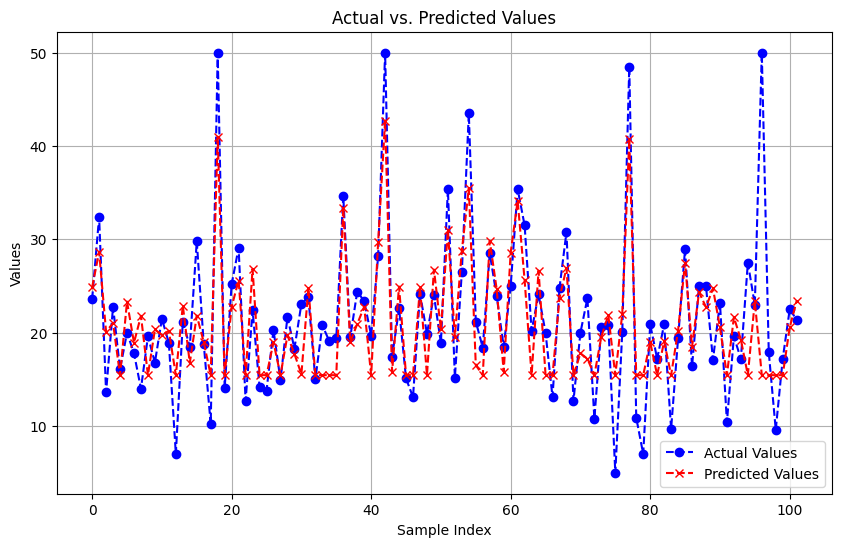

In [165]:
import matplotlib.pyplot as plt

# Flattening the arrays if they are not already 1D
y_pred = y_pred.flatten()
y_test = y_test.flatten()

# Plotting actual and predicted values in the same graph
plt.figure(figsize=(10, 6))
plt.plot(y_test, color='blue', marker='o', linestyle='dashed', label='Actual Values')
plt.plot(y_pred, color='red', marker='x', linestyle='dashed', label='Predicted Values')

plt.title('Actual vs. Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

plt.show()

# **Neural Network with Adam optimiser**

In [183]:

class LayerAdam:
    def __init__(self, input_size, output_size, activation):
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.zeros((1, output_size))
        self.activation = activation

        # Initialize Adam parameters
        self.m_weights = np.zeros_like(self.weights)
        self.v_weights = np.zeros_like(self.weights)
        self.m_bias = np.zeros_like(self.bias)
        self.v_bias = np.zeros_like(self.bias)
        self.t = 0

    def forward(self, inputs):
        self.inputs = inputs
        self.z = np.dot(inputs, self.weights) + self.bias
        return self.activation(self.z)

    def backward(self, d_output, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        d_z = d_output * self.activation(self.z, derivative=True)
        d_weights = np.dot(self.inputs.T, d_z)
        d_bias = np.sum(d_z, axis=0, keepdims=True)
        d_inputs = np.dot(d_z, self.weights.T)

        # Update t (time step)
        self.t += 1

        # Update biased first moment estimate
        self.m_weights = beta1 * self.m_weights + (1 - beta1) * d_weights
        self.m_bias = beta1 * self.m_bias + (1 - beta1) * d_bias

        # Update biased second moment estimate
        self.v_weights = beta2 * self.v_weights + (1 - beta2) * (d_weights ** 2)
        self.v_bias = beta2 * self.v_bias + (1 - beta2) * (d_bias ** 2)

        # Correct bias in first moment
        m_hat_weights = self.m_weights / (1 - beta1 ** self.t)
        m_hat_bias = self.m_bias / (1 - beta1 ** self.t)

        # Correct bias in second moment
        v_hat_weights = self.v_weights / (1 - beta2 ** self.t)
        v_hat_bias = self.v_bias / (1 - beta2 ** self.t)

        # Update weights and biases
        self.weights -= learning_rate * m_hat_weights / (np.sqrt(v_hat_weights) + epsilon)
        self.bias -= learning_rate * m_hat_bias / (np.sqrt(v_hat_bias) + epsilon)

        return d_inputs

class NeuralNetworkAdam:
    def __init__(self, input_size):
        def linear(x, derivative=False):
            return np.ones_like(x) if derivative else x

        self.layers = [
            LayerAdam(input_size, 5, relu),
            LayerAdam(5, 3, relu),
            LayerAdam(3, 1, linear)
        ]

    def forward(self, X):
        X = np.array(X)
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, X, y, learning_rate):
        X, y = np.array(X), np.array(y).reshape(-1, 1)
        output = self.forward(X)
        d_output = output - y
        for layer in reversed(self.layers):
            d_output = layer.backward(d_output, learning_rate)

    def train(self, X, y, epochs, learning_rate):
        X, y = np.array(X), np.array(y).reshape(-1, 1)
        for epoch in range(epochs):
            self.backward(X, y, learning_rate)

            loss = np.mean((self.forward(X) - y) ** 2)
            print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, X):
        return self.forward(np.array(X))

# Activation function example
def relu(x, derivative=False):
    if derivative:
        return np.where(x > 0, 1, 0)
    return np.maximum(0, x)


**1000 epochs and learning rate of 0.01**

In [167]:
# Train the model
epochs = 1000
learning_rate = 0.01
nn = NeuralNetworkAdam(X_train.shape[1])
nn.train(X_train, y_train, epochs, learning_rate)

# Predict on the test set
predictions = nn.predict(X_test)
# print("Predictions on test set:", predictions)
# Calculate the mean squared error
mse = np.mean((predictions - y_test) ** 2)
print(f"Mean Squared Error: {mse}")
# for i in range(len(predictions)):
#     print(f"Predicted: {predictions[i][0]}, Actual: {y_test[i][0]}")

Epoch 0, Loss: 606.0914108020677
Epoch 1, Loss: 605.6223903431952
Epoch 2, Loss: 605.1442597373782
Epoch 3, Loss: 604.6560040409896
Epoch 4, Loss: 604.1565106732457
Epoch 5, Loss: 603.6445654932725
Epoch 6, Loss: 603.118853659548
Epoch 7, Loss: 602.577960058366
Epoch 8, Loss: 602.0203684497782
Epoch 9, Loss: 601.4444599357241
Epoch 10, Loss: 600.8485112599739
Epoch 11, Loss: 600.2306932604781
Epoch 12, Loss: 599.5890696792264
Epoch 13, Loss: 598.9215964750662
Epoch 14, Loss: 598.2261217562261
Epoch 15, Loss: 597.5003864367015
Epoch 16, Loss: 596.7420257164503
Epoch 17, Loss: 595.9485714855676
Epoch 18, Loss: 595.1174557552229
Epoch 19, Loss: 594.2460152220484
Epoch 20, Loss: 593.331497077289
Epoch 21, Loss: 592.3710661769577
Epoch 22, Loss: 591.3618136942645
Epoch 23, Loss: 590.3007673804902
Epoch 24, Loss: 589.1849035650937
Epoch 25, Loss: 588.0111610299831
Epoch 26, Loss: 586.776456896364
Epoch 27, Loss: 585.4777046651651
Epoch 28, Loss: 584.1118345534862
Epoch 29, Loss: 582.67581626

In [168]:
for i in range(len(predictions)):
  print(f"Predicted: {predictions[i][0]}, Actual: {y_test[i]}")

Predicted: 25.6682846176907, Actual: 23.6
Predicted: 27.666538517636614, Actual: 32.4
Predicted: 23.16315247304192, Actual: 13.6
Predicted: 23.64680281569366, Actual: 22.8
Predicted: 20.952651597428158, Actual: 16.1
Predicted: 24.87136762513478, Actual: 20.0
Predicted: 22.59438002443992, Actual: 17.8
Predicted: 24.11392625863236, Actual: 14.0
Predicted: 21.409047646145808, Actual: 19.6
Predicted: 23.320911197271542, Actual: 16.8
Predicted: 22.974856312712724, Actual: 21.5
Predicted: 23.2322568851023, Actual: 18.9
Predicted: 5.383298647970357, Actual: 7.0
Predicted: 24.637010127977696, Actual: 21.2
Predicted: 21.435613776169124, Actual: 18.5
Predicted: 25.243830767533343, Actual: 29.8
Predicted: 22.570007198646245, Actual: 18.8
Predicted: 5.383298647970357, Actual: 10.2
Predicted: 34.13430540239004, Actual: 50.0
Predicted: 16.88970311453541, Actual: 14.1
Predicted: 24.597899767250578, Actual: 25.2
Predicted: 26.058089246219733, Actual: 29.1
Predicted: 20.781556015327773, Actual: 12.7
Pr

**1000 epochs and learning rate of 0.001 (slow update, needs high epochs to converge)**

In [169]:
# Train the model
epochs = 5000
learning_rate = 0.001
nn = NeuralNetworkAdam(X_train.shape[1])
nn.train(X_train, y_train, epochs, learning_rate)

# Predict on the test set
predictions = nn.predict(X_test)
# print("Predictions on test set:", predictions)
# Calculate the mean squared error
mse = np.mean((predictions - y_test) ** 2)
print(f"Mean Squared Error: {mse}")
# for i in range(len(predictions)):
#     print(f"Predicted: {predictions[i][0]}, Actual: {y_test[i][0]}")

Streaming output truncated to the last 5000 lines.
Epoch 1, Loss: 606.46365974951
Epoch 2, Loss: 606.4176660187176
Epoch 3, Loss: 606.3715763940992
Epoch 4, Loss: 606.3253893799555
Epoch 5, Loss: 606.2791039798323
Epoch 6, Loss: 606.2327158503186
Epoch 7, Loss: 606.1862187383299
Epoch 8, Loss: 606.1396082738119
Epoch 9, Loss: 606.0928765226106
Epoch 10, Loss: 606.0460174072795
Epoch 11, Loss: 605.9990249330269
Epoch 12, Loss: 605.9518931256681
Epoch 13, Loss: 605.904615213545
Epoch 14, Loss: 605.8571843535299
Epoch 15, Loss: 605.8095931016833
Epoch 16, Loss: 605.7618316865914
Epoch 17, Loss: 605.7138909554353
Epoch 18, Loss: 605.6657591777305
Epoch 19, Loss: 605.6174254488953
Epoch 20, Loss: 605.5688775981997
Epoch 21, Loss: 605.520112979759
Epoch 22, Loss: 605.4711217017807
Epoch 23, Loss: 605.4218933090059
Epoch 24, Loss: 605.3724166359289
Epoch 25, Loss: 605.3226802696441
Epoch 26, Loss: 605.2726706969597
Epoch 27, Loss: 605.2223715231473
Epoch 28, Loss: 605.1717650808424
Epoch 29, 

In [170]:
for i in range(len(predictions)):
  print(f"Predicted: {predictions[i][0]}, Actual: {y_test[i]}")

Predicted: 25.846350918350453, Actual: 23.6
Predicted: 28.105824536292957, Actual: 32.4
Predicted: 23.017559161729427, Actual: 13.6
Predicted: 23.56513266514344, Actual: 22.8
Predicted: 19.89532895527294, Actual: 16.1
Predicted: 24.9458047749287, Actual: 20.0
Predicted: 22.348937433133955, Actual: 17.8
Predicted: 24.067187291037968, Actual: 14.0
Predicted: 20.542818101773367, Actual: 19.6
Predicted: 23.18064910944155, Actual: 16.8
Predicted: 22.804444183305087, Actual: 21.5
Predicted: 23.087446006036384, Actual: 18.9
Predicted: 6.826043222189394, Actual: 7.0
Predicted: 24.68700871685547, Actual: 21.2
Predicted: 21.04559902970642, Actual: 18.5
Predicted: 24.79373324981793, Actual: 29.8
Predicted: 22.349109566030688, Actual: 18.8
Predicted: 9.286667034846726, Actual: 10.2
Predicted: 35.4100475876563, Actual: 50.0
Predicted: 14.776499143300434, Actual: 14.1
Predicted: 24.62956834318279, Actual: 25.2
Predicted: 26.287755375254697, Actual: 29.1
Predicted: 20.20084844134626, Actual: 12.7
Pre

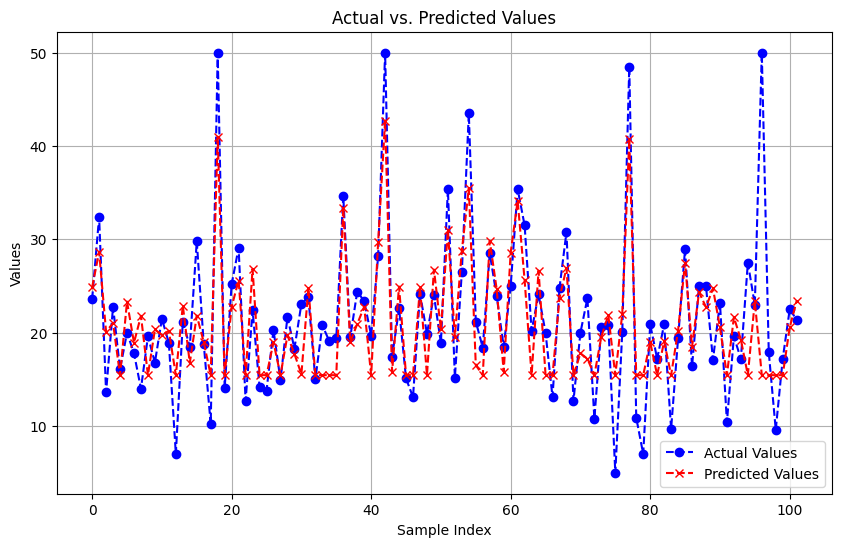

In [184]:
import matplotlib.pyplot as plt

# Flattening the arrays if they are not already 1D
y_pred = y_pred.flatten()
y_test = y_test.flatten()

# Plotting actual and predicted values in the same graph
plt.figure(figsize=(10, 6))
plt.plot(y_test, color='blue', marker='o', linestyle='dashed', label='Actual Values')
plt.plot(y_pred, color='red', marker='x', linestyle='dashed', label='Predicted Values')

plt.title('Actual vs. Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

plt.show()


# **Neural network using momentum**

In [185]:
class LayerMomentum:
    def __init__(self, input_size, output_size, learning_rate=0.01, momentum=0.9):
        # Initialize weights and biases
        self.weights = np.random.randn(input_size, output_size)
        self.biases = np.zeros((1, output_size))
        # Initialize velocity for momentum
        self.velocity_w = np.zeros_like(self.weights)
        self.velocity_b = np.zeros_like(self.biases)
        # Hyperparameters
        self.learning_rate = learning_rate
        self.momentum = momentum

    def forward(self, X):
        self.input = X
        return np.dot(X, self.weights) + self.biases

    def backward(self, gradient):
        # Compute gradients
        grad_weights = np.dot(self.input.T, gradient) / len(self.input)
        grad_biases = np.mean(gradient, axis=0, keepdims=True)

        # Update velocities
        self.velocity_w = self.momentum * self.velocity_w - self.learning_rate * grad_weights
        self.velocity_b = self.momentum * self.velocity_b - self.learning_rate * grad_biases

        # Update weights and biases
        self.weights += self.velocity_w
        self.biases += self.velocity_b

        # Return gradient for the previous layer
        return np.dot(gradient, self.weights.T)

class NeuralNetworkMomentum:
    def __init__(self, learning_rate=0.01, momentum=0.9, n_epochs=100):
        self.layers = []
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.n_epochs = n_epochs

    def add_layer(self, input_size, output_size):
        layer = LayerMomentum(input_size, output_size, self.learning_rate, self.momentum)
        self.layers.append(layer)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, gradient):
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)

    def train(self, X_train, y_train):
        for epoch in range(self.n_epochs):
            # Forward pass
            predictions = self.forward(X_train)

            # Calculate loss and gradient (MSE)
            errors = predictions - y_train
            mse = np.mean(errors ** 2)
            print(f"Epoch {epoch + 1}/{self.n_epochs}, Mean Squared Error: {mse}")

            # Backward pass
            self.backward(errors)

    def predict(self, X):
        return self.forward(X)

 **1000 epochs and learning rate of 0.01 (not converging)**

In [186]:
input_size = X_train.shape[1]  # Number of features in the input
nn = NeuralNetwork(input_size)

# Train the model
epochs = 1000
learning_rate = 0.01
nn.train(X_train, y_train, epochs, learning_rate)

# Predict on the test set
predictions = nn.predict(X_test)
mse = np.mean((predictions - y_test) ** 2)
print(f"Mean Squared Error: {mse}")
# print("Predictions on test set:", predictions)

Epoch 0, Loss: 4889.566704217227
Epoch 1, Loss: 44471.44380866422
Epoch 2, Loss: 410271.31925712165
Epoch 3, Loss: 3790847.448201586
Epoch 4, Loss: 35032779.801454745
Epoch 5, Loss: 323758221.83727914
Epoch 6, Loss: 2992043266.9555545
Epoch 7, Loss: 27651266339.92061
Epoch 8, Loss: 255541942291.03458
Epoch 9, Loss: 2361616413160.849
Epoch 10, Loss: 21825114243151.33
Epoch 11, Loss: 201698975788791.3
Epoch 12, Loss: 1864021254648978.5
Epoch 13, Loss: 1.7226538826963284e+16
Epoch 14, Loss: 1.5920078122326314e+17
Epoch 15, Loss: 1.4712699397529078e+18
Epoch 16, Loss: 1.3596888275220472e+19
Epoch 17, Loss: 1.2565700268427752e+20
Epoch 18, Loss: 1.1612717560070186e+21
Epoch 19, Loss: 1.0732009060314462e+22
Epoch 20, Loss: 9.918093493180214e+22
Epoch 21, Loss: 9.16590528265743e+23
Epoch 22, Loss: 8.470763026020693e+24
Epoch 23, Loss: 7.828340358127281e+25
Epoch 24, Loss: 7.23463902536691e+26
Epoch 25, Loss: 6.685964001683087e+27
Epoch 26, Loss: 6.17890049179544e+28
Epoch 27, Loss: 5.71029267

<ipython-input-156-eeb114da14c1>:30: RuntimeWarning: overflow encountered in square
  loss = np.mean((self.forward(X) - y) ** 2)


Epoch 368, Loss: inf
Epoch 369, Loss: inf
Epoch 370, Loss: inf
Epoch 371, Loss: inf
Epoch 372, Loss: inf
Epoch 373, Loss: inf
Epoch 374, Loss: inf
Epoch 375, Loss: inf
Epoch 376, Loss: inf
Epoch 377, Loss: inf
Epoch 378, Loss: inf
Epoch 379, Loss: inf
Epoch 380, Loss: inf
Epoch 381, Loss: inf
Epoch 382, Loss: inf
Epoch 383, Loss: inf
Epoch 384, Loss: inf
Epoch 385, Loss: inf
Epoch 386, Loss: inf
Epoch 387, Loss: inf
Epoch 388, Loss: inf
Epoch 389, Loss: inf
Epoch 390, Loss: inf
Epoch 391, Loss: inf
Epoch 392, Loss: inf
Epoch 393, Loss: inf
Epoch 394, Loss: inf
Epoch 395, Loss: inf
Epoch 396, Loss: inf
Epoch 397, Loss: inf
Epoch 398, Loss: inf
Epoch 399, Loss: inf
Epoch 400, Loss: inf
Epoch 401, Loss: inf
Epoch 402, Loss: inf
Epoch 403, Loss: inf
Epoch 404, Loss: inf
Epoch 405, Loss: inf
Epoch 406, Loss: inf
Epoch 407, Loss: inf
Epoch 408, Loss: inf
Epoch 409, Loss: inf
Epoch 410, Loss: inf
Epoch 411, Loss: inf
Epoch 412, Loss: inf
Epoch 413, Loss: inf
Epoch 414, Loss: inf
Epoch 415, Lo

<ipython-input-154-95a821ab8954>:19: RuntimeWarning: invalid value encountered in subtract
  self.bias -= learning_rate * d_bias
<ipython-input-154-95a821ab8954>:13: RuntimeWarning: invalid value encountered in multiply
  d_z = d_output * self.activation(self.z, derivative=True)


Epoch 763, Loss: nan
Epoch 764, Loss: nan
Epoch 765, Loss: nan
Epoch 766, Loss: nan
Epoch 767, Loss: nan
Epoch 768, Loss: nan
Epoch 769, Loss: nan
Epoch 770, Loss: nan
Epoch 771, Loss: nan
Epoch 772, Loss: nan
Epoch 773, Loss: nan
Epoch 774, Loss: nan
Epoch 775, Loss: nan
Epoch 776, Loss: nan
Epoch 777, Loss: nan
Epoch 778, Loss: nan
Epoch 779, Loss: nan
Epoch 780, Loss: nan
Epoch 781, Loss: nan
Epoch 782, Loss: nan
Epoch 783, Loss: nan
Epoch 784, Loss: nan
Epoch 785, Loss: nan
Epoch 786, Loss: nan
Epoch 787, Loss: nan
Epoch 788, Loss: nan
Epoch 789, Loss: nan
Epoch 790, Loss: nan
Epoch 791, Loss: nan
Epoch 792, Loss: nan
Epoch 793, Loss: nan
Epoch 794, Loss: nan
Epoch 795, Loss: nan
Epoch 796, Loss: nan
Epoch 797, Loss: nan
Epoch 798, Loss: nan
Epoch 799, Loss: nan
Epoch 800, Loss: nan
Epoch 801, Loss: nan
Epoch 802, Loss: nan
Epoch 803, Loss: nan
Epoch 804, Loss: nan
Epoch 805, Loss: nan
Epoch 806, Loss: nan
Epoch 807, Loss: nan
Epoch 808, Loss: nan
Epoch 809, Loss: nan
Epoch 810, Lo

**1000 epochs and learning rate of 0.001 (loss not optimising after a certain iteration)**

In [187]:
input_size = X_train.shape[1]  # Number of features in the input
nn = NeuralNetwork(input_size)

# Train the model
epochs = 1000
learning_rate = 0.001
nn.train(X_train, y_train, epochs, learning_rate)

# Predict on the test set
predictions = nn.predict(X_test)
mse = np.mean((predictions - y_test) ** 2)
print(f"Mean Squared Error: {mse}")
# print("Predictions on test set:", predictions)

Epoch 0, Loss: 271.47150442206987
Epoch 1, Loss: 152.40197368695996
Epoch 2, Loss: 109.60516255171063
Epoch 3, Loss: 92.44268453925883
Epoch 4, Loss: 85.56537877947137
Epoch 5, Loss: 84.61775292738301
Epoch 6, Loss: 78.35259862895134
Epoch 7, Loss: 79.09647262747008
Epoch 8, Loss: 79.69826896908583
Epoch 9, Loss: 91.91398679466442
Epoch 10, Loss: 75.70531645861725
Epoch 11, Loss: 74.66905917580878
Epoch 12, Loss: 74.04643365070322
Epoch 13, Loss: 76.05194645414679
Epoch 14, Loss: 92.47095416773048
Epoch 15, Loss: 80.64829931686276
Epoch 16, Loss: 102.91972886719884
Epoch 17, Loss: 86.99767621173513
Epoch 18, Loss: 76.34135676434197
Epoch 19, Loss: 75.25179756045313
Epoch 20, Loss: 74.49233514358178
Epoch 21, Loss: 76.0467782409433
Epoch 22, Loss: 84.9672802528092
Epoch 23, Loss: 107.97734583160155
Epoch 24, Loss: 94.3698616939479
Epoch 25, Loss: 89.53626560850708
Epoch 26, Loss: 87.81929494142115
Epoch 27, Loss: 87.20939948894157
Epoch 28, Loss: 86.99275486589357
Epoch 29, Loss: 86.915

**1000 epochs and 0.0001 learning rate (better convergence)**

In [188]:
input_size = X_train.shape[1]  # Number of features in the input
nn = NeuralNetwork(input_size)

# Train the model
epochs = 1000
learning_rate = 0.0001
nn.train(X_train, y_train, epochs, learning_rate)

# Predict on the test set
predictions = nn.predict(X_test)
mse = np.mean((predictions - y_test) ** 2)
print(f"Mean Squared Error: {mse}")
# print("Predictions on test set:", predictions)

Epoch 0, Loss: 565.413298163595
Epoch 1, Loss: 527.5283271566647
Epoch 2, Loss: 492.64262787558494
Epoch 3, Loss: 460.5187542963421
Epoch 4, Loss: 430.9380585638283
Epoch 5, Loss: 403.6992027275806
Epoch 6, Loss: 378.61678835592284
Epoch 7, Loss: 355.5200946182711
Epoch 8, Loss: 334.2519162882431
Epoch 9, Loss: 314.66749374080484
Epoch 10, Loss: 296.6335276597948
Epoch 11, Loss: 280.0272717492979
Epoch 12, Loss: 264.7356972733539
Epoch 13, Loss: 250.6547237374243
Epoch 14, Loss: 237.6885104752656
Epoch 15, Loss: 225.74880431941833
Epoch 16, Loss: 214.75433891527064
Epoch 17, Loss: 204.63028159016184
Epoch 18, Loss: 195.30772401268544
Epoch 19, Loss: 186.72321317540457
Epoch 20, Loss: 178.81831950865364
Epoch 21, Loss: 171.539239185835
Epoch 22, Loss: 164.83642791333855
Epoch 23, Loss: 158.66426371251424
Epoch 24, Loss: 152.98073639845717
Epoch 25, Loss: 147.74716164207652
Epoch 26, Loss: 142.9279176692442
Epoch 27, Loss: 138.49020280489424
Epoch 28, Loss: 134.40381221182497
Epoch 29, L

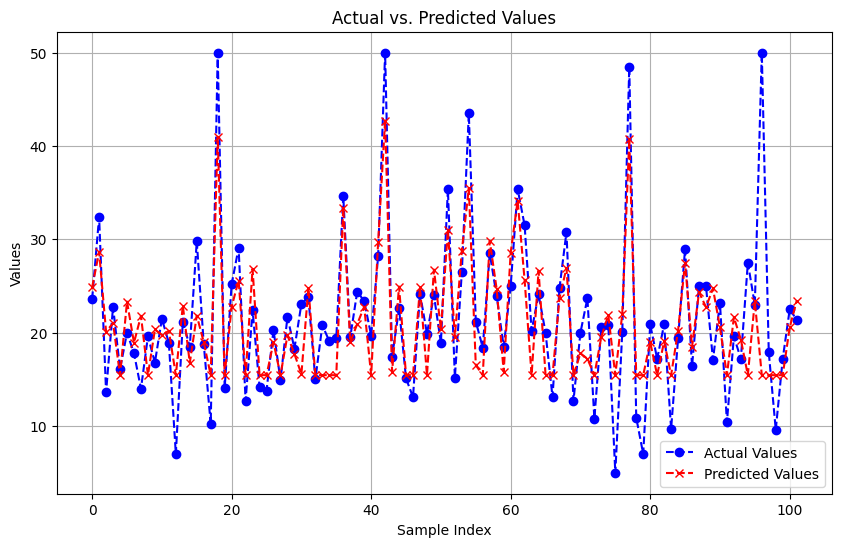

In [190]:
import matplotlib.pyplot as plt

# Flattening the arrays if they are not already 1D
y_pred = y_pred.flatten()
y_test = y_test.flatten()

# Plotting actual and predicted values in the same graph
plt.figure(figsize=(10, 6))
plt.plot(y_test, color='blue', marker='o', linestyle='dashed', label='Actual Values')
plt.plot(y_pred, color='red', marker='x', linestyle='dashed', label='Predicted Values')

plt.title('Actual vs. Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

plt.show()

# **Using the best performing model with two additional neurons**

In [191]:
class LayerAdd2:
    def __init__(self, input_size, output_size, activation):
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.zeros((1, output_size))
        self.activation = activation

    def forward(self, inputs):
        self.inputs = inputs
        self.z = np.dot(inputs, self.weights) + self.bias
        return self.activation(self.z)

    def backward(self, d_output, learning_rate):
        d_z = d_output * self.activation(self.z, derivative=True)
        d_weights = np.dot(self.inputs.T, d_z)
        d_bias = np.sum(d_z, axis=0, keepdims=True)
        d_inputs = np.dot(d_z, self.weights.T)

        self.weights -= learning_rate * d_weights
        self.bias -= learning_rate * d_bias
        return d_inputs

class NeuralNetworkAdd2:
    def __init__(self, input_size):
        def linear(x, derivative=False):
            return np.ones_like(x) if derivative else x

        self.layers = [
            LayerAdd2(input_size, 5, relu),
            LayerAdd2(5, 3, relu),
            LayerAdd2(3,2,relu),
            LayerAdd2(2, 1, linear)
        ]

    def forward(self, X):
        X = np.array(X)
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, X, y, learning_rate):
        X, y = np.array(X), np.array(y).reshape(-1, 1)
        output = self.forward(X)
        d_output = output - y
        for layer in reversed(self.layers):
            d_output = layer.backward(d_output, learning_rate)

    def train(self, X, y, epochs, learning_rate):
        X, y = np.array(X), np.array(y).reshape(-1, 1)
        for epoch in range(epochs):
            self.backward(X, y, learning_rate)

            loss = np.mean((self.forward(X) - y) ** 2)
            print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, X):
        return self.forward(np.array(X))


In [192]:

model = NeuralNetworkAdd2(input_size=X_train.shape[1])
model.train(X_train, y_train, epochs=1000, learning_rate=0.00001)



Epoch 0, Loss: 602.3648476469255
Epoch 1, Loss: 598.2080903418681
Epoch 2, Loss: 594.0848518750953
Epoch 3, Loss: 589.9948618772852
Epoch 4, Loss: 585.9378522434766
Epoch 5, Loss: 581.913557030621
Epoch 6, Loss: 577.9217124401482
Epoch 7, Loss: 573.962056800676
Epoch 8, Loss: 570.034330550855
Epoch 9, Loss: 566.1382762223559
Epoch 10, Loss: 562.2736384229908
Epoch 11, Loss: 558.4401638199721
Epoch 12, Loss: 554.6376011233068
Epoch 13, Loss: 550.8657010693233
Epoch 14, Loss: 547.1242164043321
Epoch 15, Loss: 543.4129018684179
Epoch 16, Loss: 539.7315141793624
Epoch 17, Loss: 536.0798120166972
Epoch 18, Loss: 532.4575560058844
Epoch 19, Loss: 528.8645087026252
Epoch 20, Loss: 525.3004345772956
Epoch 21, Loss: 521.7650999995063
Epoch 22, Loss: 518.2582732227888
Epoch 23, Loss: 514.7797243694033
Epoch 24, Loss: 511.32922541527006
Epoch 25, Loss: 507.9065501750225
Epoch 26, Loss: 504.51147428718
Epoch 27, Loss: 501.14377519944054
Epoch 28, Loss: 497.8032321540927
Epoch 29, Loss: 494.4896261

In [193]:
mse = np.mean((predictions - y_test) ** 2)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 74.66690827994748


# **Adding L2 regularization and checking**

In [194]:
class LayerL2:
    def __init__(self, input_size, output_size, activation, l2_lambda=0.01):
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.zeros((1, output_size))
        self.activation = activation
        self.l2_lambda = l2_lambda  # L2 regularization parameter

    def forward(self, inputs):
        self.inputs = inputs
        self.z = np.dot(inputs, self.weights) + self.bias
        return self.activation(self.z)

    def backward(self, d_output, learning_rate):
        d_z = d_output * self.activation(self.z, derivative=True)
        d_weights = np.dot(self.inputs.T, d_z) + self.l2_lambda * self.weights  # Add L2 regularization term
        d_bias = np.sum(d_z, axis=0, keepdims=True)
        d_inputs = np.dot(d_z, self.weights.T)

        self.weights -= learning_rate * d_weights
        self.bias -= learning_rate * d_bias
        return d_inputs

class NeuralNetworkL2:
    def __init__(self, input_size, l2_lambda=0.01):
        def linear(x, derivative=False):
            return np.ones_like(x) if derivative else x

        self.layers = [
            LayerL2(input_size, 5, relu, l2_lambda),
            LayerL2(5, 3, relu, l2_lambda),
            LayerL2(3, 2, relu, l2_lambda),
            LayerL2(2, 1, linear, l2_lambda)
        ]

    def forward(self, X):
        X = np.array(X)
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, X, y, learning_rate):
        X, y = np.array(X), np.array(y).reshape(-1, 1)
        output = self.forward(X)
        d_output = output - y
        for layer in reversed(self.layers):
            d_output = layer.backward(d_output, learning_rate)

    def train(self, X, y, epochs, learning_rate):
        X, y = np.array(X), np.array(y).reshape(-1, 1)
        for epoch in range(epochs):
            self.backward(X, y, learning_rate)

            loss = np.mean((self.forward(X) - y) ** 2)
            # Add L2 regularization term to the loss
            l2_loss = sum(layer.l2_lambda * np.sum(np.square(layer.weights)) for layer in self.layers)
            total_loss = loss + l2_loss

            print(f"Epoch {epoch}, Loss: {total_loss}")

    def predict(self, X):
        return self.forward(np.array(X))

In [195]:

model = NeuralNetworkL2(input_size=X_train.shape[1])
model.train(X_train, y_train, epochs=1000, learning_rate=0.00001)



Epoch 0, Loss: 602.3648738627269
Epoch 1, Loss: 598.2081166423603
Epoch 2, Loss: 594.0848781754056
Epoch 3, Loss: 589.9948881774147
Epoch 4, Loss: 585.9378785434269
Epoch 5, Loss: 581.9135833303933
Epoch 6, Loss: 577.9217387397441
Epoch 7, Loss: 573.9620831000966
Epoch 8, Loss: 570.0343568501022
Epoch 9, Loss: 566.1383025214307
Epoch 10, Loss: 562.2736647218945
Epoch 11, Loss: 558.4401901187064
Epoch 12, Loss: 554.6376274218727
Epoch 13, Loss: 550.8657273677222
Epoch 14, Loss: 547.124242702565
Epoch 15, Loss: 543.4129281664865
Epoch 16, Loss: 539.7315404772679
Epoch 17, Loss: 536.079838314441
Epoch 18, Loss: 532.4575823034675
Epoch 19, Loss: 528.8645350000489
Epoch 20, Loss: 525.3004608745613
Epoch 21, Loss: 521.7651262966151
Epoch 22, Loss: 518.2582995197419
Epoch 23, Loss: 514.7797506662018
Epoch 24, Loss: 511.3292517119154
Epoch 25, Loss: 507.90657647151585
Epoch 26, Loss: 504.5115005835224
Epoch 27, Loss: 501.14380149563334
Epoch 28, Loss: 497.80325845013675
Epoch 29, Loss: 494.489

In [196]:
mse = np.mean((predictions - y_test) ** 2)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 74.66690827994748
